<a href="https://colab.research.google.com/github/ADIITJ/basic-computer-vision/blob/main/pytorch_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Computer vision library
* `torchvision` is the base domain library for computer vision
* `torchvision.datasets` - Get dataset and data loading function for computer vision
* `torchvision.models` - Get pretrained computer vision model
* `torchvision.transforms` - Function for manipulating your vision data to convert it into numbers [ data understood my ML model ]
* `torch.utils.data.Dataset1` - Base dataset for pytorch
* `torch.utils.data.DataLoader` - Creates python iterables over a dataset

In [ ]:
import torch
from torch import nn
import torchvision
from torchvision import transforms, datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
print(torch.__version__)
print(torchvision.__version__)

2.0.1+cu118
0.15.2+cu118


In [ ]:
## Getting a dataset
train_data = datasets.FashionMNIST(
    root = 'data',
    train = True,
    download = True,
    transform = ToTensor(),
    target_transform = None
)

test_data = datasets.FashionMNIST(
    root = 'data',
    train = False,
    download = True,
    transform = ToTensor(),
    target_transform = None
)


100%|██████████| 26421880/26421880 [00:03<00:00, 8457937.67it/s] 


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 141854.52it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2670274.72it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 23520998.90it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

(torch.Size([1, 28, 28]), 9)

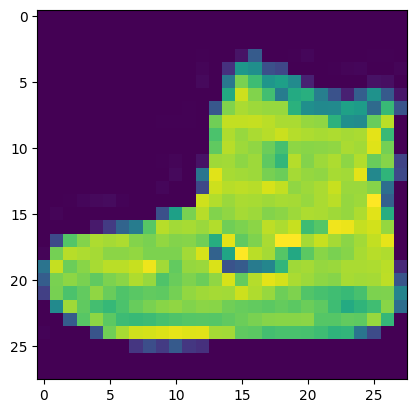

In [ ]:
image, label = train_data[0]
plt.imshow(image.squeeze())
image.shape, label

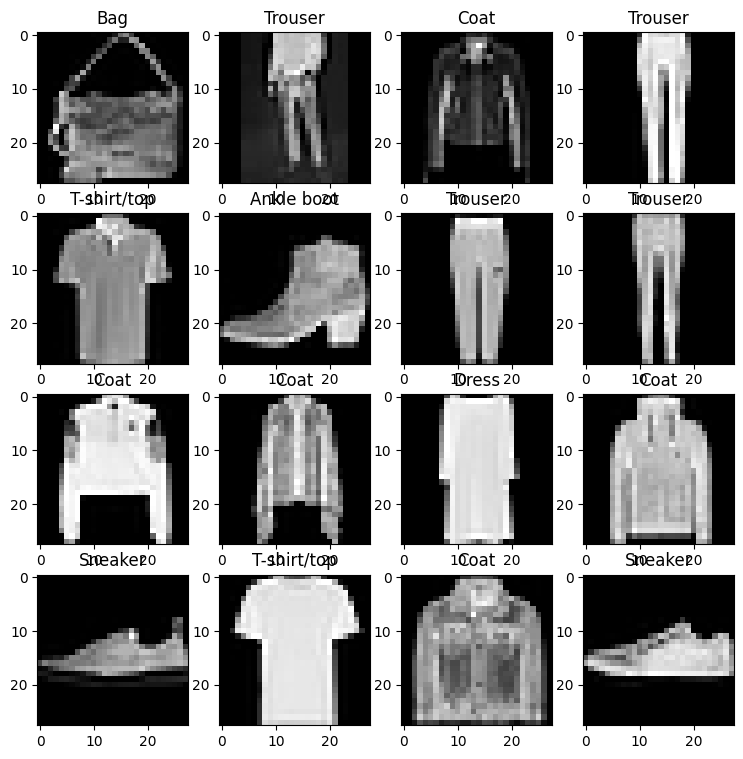

In [ ]:
fig = plt.figure(figsize = (9,9))
row, col = 4,4
for i in range(1, row*col + 1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(row, col, i)
  plt.imshow(img.squeeze(), cmap= 'gray')
  plt.title(class_names[label])
  plt.axis(True)

In [ ]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset = train_data, shuffle = True, batch_size = 32)
test_dataloader = DataLoader(dataset = test_data, shuffle = True, batch_size = 32)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7826f3b619f0>,
 <torch.utils.data.dataloader.DataLoader at 0x7826f3b615d0>)

In [ ]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
test_features_batch, test_labels_batch = next(iter(test_dataloader))

## Model_0 - Baseline model


In [ ]:
# Create flatten model
flaten_model = nn.Flatten()


In [ ]:
class FassionMNISTModelV0(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shapes: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = input_shape, out_features = hidden_units),
        nn.Linear(in_features = hidden_units, out_features = output_shapes)
    )

  def forward(self,x):
    return self.layer_stack(x)

In [ ]:
model_0 = FassionMNISTModelV0(input_shape = 784, hidden_units = 10, output_shapes = len(class_names)).cpu()
model_0

FassionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [ ]:
dummy_x = torch.rand([1,1,28,28])
model_0(dummy_x)

tensor([[-0.3675, -0.2173, -0.3256,  0.3728,  0.0611,  0.2774, -0.1152, -0.1126,
          0.3776, -0.4299]], grad_fn=<AddmmBackward0>)

## Loss function and optimizer

* Loss function used would be `nn.CrossEntropy()`
* optimizer would be `torch.optim.SGD`
* Evaluation metric would be accuracy - `torchmetrics.Accuracy`

In [ ]:
import requests
from pathlib import Path

if Path('helper_function.py').is_file() :
  print("Skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open('helper_function.py', 'wb') as f:
    f.write(request.content)

In [ ]:
from helper_function import accuracy_fn

#set up loss and optimizer

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_0.parameters(), lr = 0.01)


In [ ]:
# Making a fucntion to calculate time
def print_time(start: float, end: float, device: torch.device = None):
  print(f'Time take on device - {device} is {end-start : .3f}')

In [ ]:
import time
start = time.time()
# code
end = time.time()

print_time(start = start, end = end, device = 'cpu')

Time take on device - cpu is  0.000


## Build training and testing loop

In [ ]:
from tqdm.auto import tqdm

torch.manual_seed(42)
train_time_start_on_cpu = time.time()

epochs = 3

for epoch in tqdm(range(epochs)):
  print(f'epoch : {epoch}\n - - - - - - - - - -')
  train_loss = 0

  # Add a loop to loop through training
  for batch, (X,y) in enumerate(train_dataloader):
    model_0.train()
    y_pred = model_0(X)

    loss = loss_fn(y_pred, y)

    train_loss+= loss

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

  train_loss /= len(train_dataloader)
  print('train loss =',train_loss)

  ## testing loop

  test_loss, test_acc = 0.0,0.0
  model_0.eval()
  with torch.inference_mode():
    for (X,y) in test_dataloader:
      test_pred = model_0(X)

      test_loss += loss_fn(test_pred, y)
    test_loss /= len(test_dataloader)
    print("test loss = ", test_loss)

  train_time_end_on_cpu = time.time()
  print_time(train_time_start_on_cpu,train_time_end_on_cpu)

  0%|          | 0/3 [00:00<?, ?it/s]

epoch : 0
 - - - - - - - - - -
train loss = tensor(0.8953, grad_fn=<DivBackward0>)
test loss =  tensor(0.6423)
Time take on device - None is  22.099
epoch : 1
 - - - - - - - - - -
train loss = tensor(0.5677, grad_fn=<DivBackward0>)
test loss =  tensor(0.5524)
Time take on device - None is  34.931
epoch : 2
 - - - - - - - - - -
train loss = tensor(0.5062, grad_fn=<DivBackward0>)
test loss =  tensor(0.5150)
Time take on device - None is  48.329


In [ ]:
torch.manual_seed(42)

def eval_model(model : torch.nn.Module,
               data_loader : torch.utils.data.DataLoader,
               loss_fn : torch.nn.Module,
               accuracy_fn):
  loss, acc = 0,0
  model_0.eval()
  with torch.inference_mode():
    for X,y in data_loader:
      y_pred = model_0(X)
      loss += loss_fn(y_pred,y)
      acc += accuracy_fn(y_true = y,
                         y_pred = y_pred.argmax(dim = 1))

    loss /= len(data_loader)
    acc /= len(data_loader)

  return {'model_name': model.__class__.__name__,
          'model_loss': loss.item(),
          'model_acc': acc}

model_0_eval =  eval_model(model = model_0,
               data_loader = test_dataloader,
               loss_fn = loss_fn,
               accuracy_fn= accuracy_fn)
model_0_eval

{'model_name': 'FassionMNISTModelV0',
 'model_loss': 0.5142502188682556,
 'model_acc': 82.1785143769968}

In [ ]:
## Device diagnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

device

'cuda'

In [ ]:
class FashionMNISTModelV1(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = input_shape,
                  out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units,
                  out_features = output_shape),
        nn.ReLU(),
    )

  def forward(self, x):
    return self.layer_stack(x)

In [ ]:
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape = 784, hidden_units = 20, output_shape = len(class_names)).to(device)
model_1.parameters()

<generator object Module.parameters at 0x7826f397dc40>

In [ ]:
from helper_function import accuracy_fn

#set up loss and optimizer

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_0.parameters(), lr = 0.1)


In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [ ]:
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epoch = 3
for epochs in tqdm(range(epoch)):
  print("for epoch = ", epochs)
  train_step(model = model_1,
             loss_fn = loss_fn,
             optimizer = optimizer,
             accuracy_fn = accuracy_fn,
             data_loader = train_dataloader)
  test_step(model = model_1,
             loss_fn = loss_fn,
             accuracy_fn = accuracy_fn,
             data_loader = test_dataloader)
  print("----------------------")

train_time_end_on_gpu = timer()
print_time(start = train_time_start_on_gpu, end = train_time_end_on_gpu, device = device)

  0%|          | 0/3 [00:00<?, ?it/s]

for epoch =  0
Train loss: 2.29762 | Train accuracy: 16.09%
Test loss: 2.29791 | Test accuracy: 16.33%

----------------------
for epoch =  1
Train loss: 2.29762 | Train accuracy: 16.09%
Test loss: 2.29784 | Test accuracy: 16.32%

----------------------
for epoch =  2
Train loss: 2.29763 | Train accuracy: 16.09%
Test loss: 2.29788 | Test accuracy: 16.32%

----------------------
Time take on device - cuda is  37.189


## Making a Convolutional neural network.

> # 1st CNN Model !!!

Conv2d is a model for 2 dimentional data.
Hyper parameters-
* kernel_size - 3 means (3 x 3). it is the dimentions of the boxes which move over the image considering the image divided in boxes of number = (input_shape x input_shape)
* stride - it is the value which determines how the boxes cover the image in a line.
* padding - it is the value that determines how much of the image boundary is useless

MaxPool2d - it allows us the reduce the size of the input while preserving its most important features. this is by taking the max value out of the given dimension of the boxes given in the input.
Hyper parameters-
* kernel_size - It takes the max value of the dimension given by kernel_size


In [ ]:
class FashionMNISTModelV2(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size= 3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size= 3,
                  stride=1,
                  padding=1),
        nn.MaxPool2d(kernel_size = 2)
    )
    self.Classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features= hidden_units*7*7,
                  out_features= output_shape)
    )
  def forward(self,x):
    x = self.conv_block(x)
    #print(x.shape)
    x = self.conv_block2(x)
    #print(x.shape)
    x = self.Classifier(x)
    return x

In [ ]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape = 1, output_shape = len(class_names), hidden_units = 10).to(device)

In [ ]:
from helper_function import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_2.parameters(), lr = 0.1)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
from timeit import default_timer as timer

train_start_2 = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
  train_step(model = model_2, data_loader= train_dataloader, loss_fn= loss_fn, optimizer= optimizer, accuracy_fn= accuracy_fn, device=device)
  test_step(model = model_2, data_loader= test_dataloader, loss_fn= loss_fn, accuracy_fn= accuracy_fn, device=device)

train_end_2 = timer()
print_time(start = train_start_2, end = train_end_2, device = device)

  0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.23097 | Train accuracy: 91.55%
Test loss: 0.28414 | Test accuracy: 89.98%

Train loss: 0.22998 | Train accuracy: 91.68%
Test loss: 0.32483 | Test accuracy: 88.97%

Train loss: 0.22560 | Train accuracy: 91.76%
Test loss: 0.30392 | Test accuracy: 89.39%

Time take on device - cuda is  39.495


In [ ]:
model_2_results = eval_model(model = model_2, data_loader = test_dataloader, loss_fn = loss_fn, accuracy_fn= accuracy_fn)
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.5145367383956909,
 'model_acc': 82.15854632587859}

In [ ]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

In [ ]:
def make_prediction(model:torch.nn.Module, data:list, device:torch.device = device):
  preds_probs = []
  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample, dim = 0)
      sample = sample.to(device)
      pred_logit = model(sample)

      pred_prob = torch.softmax(pred_logit.squeeze(),dim=0)
      print(pred_prob)
      preds_probs.append(pred_prob.cpu())
  return torch.stack(preds_probs)


In [ ]:
pred_probs = make_prediction(model = model_2, data = test_samples, device = device)
print(pred_probs)

tensor([4.2319e-08, 1.7706e-11, 1.6317e-10, 4.1667e-13, 2.7632e-10, 9.9881e-01,
        1.3378e-06, 1.3915e-07, 7.9773e-07, 1.1905e-03], device='cuda:0')
tensor([2.3763e-03, 9.8876e-01, 8.1372e-05, 6.6908e-03, 1.7843e-03, 1.4033e-08,
        2.9117e-04, 8.8109e-06, 1.8264e-06, 2.5618e-06], device='cuda:0')
tensor([1.9217e-08, 5.3044e-11, 3.9861e-10, 2.4337e-09, 1.7785e-10, 2.4126e-06,
        2.6281e-08, 9.9813e-01, 2.0335e-06, 1.8665e-03], device='cuda:0')
tensor([1.2624e-03, 2.0910e-05, 3.1682e-01, 2.9842e-04, 6.8094e-01, 1.1672e-08,
        6.3748e-04, 1.3607e-06, 1.7288e-05, 3.0511e-06], device='cuda:0')
tensor([4.6080e-03, 1.2200e-07, 1.1390e-05, 9.9493e-01, 2.0005e-04, 8.6906e-08,
        2.4980e-04, 2.0858e-06, 2.1023e-08, 3.7505e-07], device='cuda:0')
tensor([9.2170e-01, 1.3173e-06, 5.2772e-03, 1.0496e-02, 1.3520e-04, 1.1004e-09,
        6.2341e-02, 9.7505e-06, 4.0668e-05, 1.2942e-06], device='cuda:0')
tensor([3.6295e-04, 6.7103e-08, 4.1747e-01, 5.3747e-07, 4.4406e-01, 3.2196e-

In [ ]:
pred_classes = pred_probs.argmax(dim = 1)

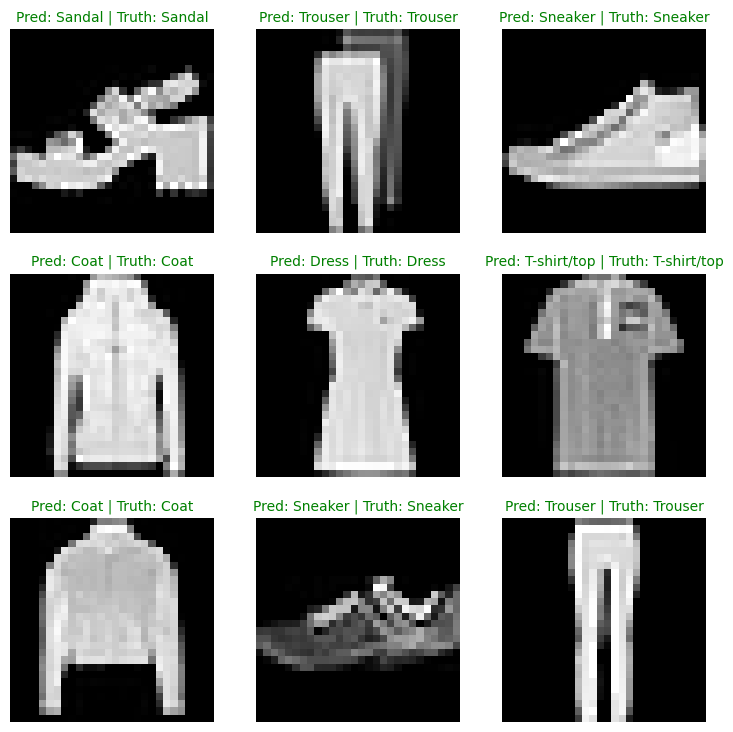

In [ ]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

In [ ]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_2(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

In [ ]:
y_preds = []

model_2.eval()
with torch.inference_mode():
  for X,y in tqdm(test_dataloader, desc = 'Making prediction with test dataset'):
    X=X.to(device)
    y=y.to(device)
    y_logit = model_2(X)
    y_pred = torch.softmax(y_logit.squeeze(), dim = 0).argmax(dim = 1)
    y_preds.append(y_pred.cpu())

#print(y_preds)
y_pred_tensor = torch.cat(y_preds)
print(y_pred_tensor)

Making prediction with test dataset:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([1, 8, 7,  ..., 4, 2, 8])


In [ ]:
!pip install -q torchmetrics -U mlxtend
import torchmetrics, mlxtend
print(mlxtend.__version__)

0.22.0


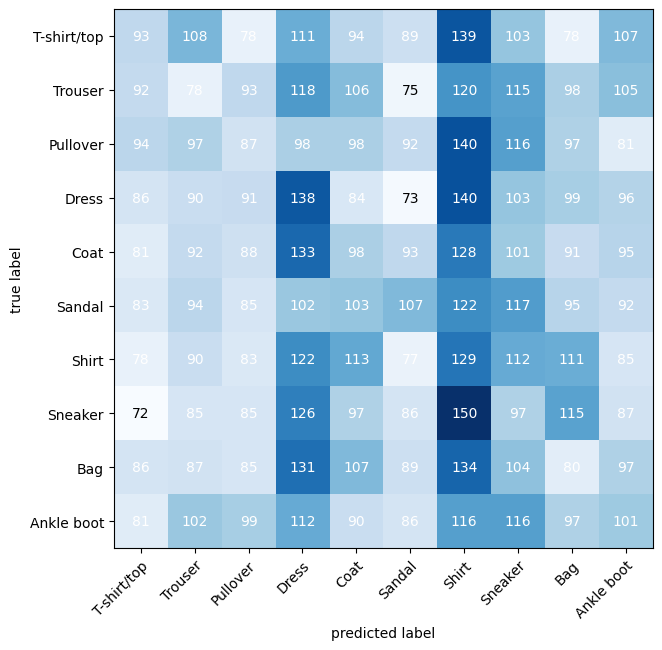

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(class_names), task = 'multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
)